In [165]:
%matplotlib inline

In [166]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import duckdb

sns.set(style="whitegrid")

In [167]:
print(duckdb.__version__)

0.5.1


In [168]:
import warnings
warnings.filterwarnings('ignore')

* [Pairwise EDA - Target Variable: rating](#pairwise_eda_rating)
    - [neighborhood vs. rating](#neighborhood_vs_rating)
    - [host_since vs. rating](#host_since_vs_rating)
    - [host_location vs. rating](#host_location_vs_rating)
    - [host_response_time vs. rating](#host_response_time_vs_rating)
    - [host_response_rate vs. rating](#host_respone_rate_vs_rating)
    - [host_acceptance_rate vs. rating](#host_acceptance_rate_vs_rating)
    - [host_is_superhost vs. rating](#host_is_superhost_vs_rating)
    - [host_listings_count vs. rating](#host_listings_count_vs_rating)
    - [host_total_listings_count vs. rating](#host_total_listings_count_vs_rating)
    - [host_verifications vs. rating](#host_verifications_vs_rating)
    - [host_has_profile_pic vs. rating](#host_has_profile_pic_vs_rating)
    - [host_identity_verified vs. rating](#host_identity_verified_vs_rating)

<a id="dataloading"></a> 
# Data Loading

In [169]:
con = duckdb.connect(database='ps6.duckdb', read_only=False)

In [170]:
# Loading dataset
# connect to database

# read the result of an arbitrary SQL query to a Pandas DataFrame
all_listings = con.execute("SELECT * from all_listings").df()
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28076 entries, 0 to 28075
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            28076 non-null  int64         
 1   listing_url                                   28076 non-null  object        
 2   scrape_id                                     28076 non-null  int64         
 3   last_scraped                                  28076 non-null  datetime64[ns]
 4   name                                          28074 non-null  object        
 5   description                                   27666 non-null  object        
 6   neighborhood_overview                         18547 non-null  object        
 7   picture_url                                   28076 non-null  object        
 8   host_id                                       28076 non-null  int3

In [171]:
# read the result of an arbitrary SQL query to a Pandas DataFrame
neighborhoods = con.execute("SELECT * from neighborhoods").df()
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   neighbourhood_group  0 non-null      object
 1   neighbourhood        39 non-null     object
 2   type_outer           39 non-null     object
 3   feature_type         39 non-null     object
 4   geometry_type        39 non-null     object
 5   coordinates          39 non-null     object
dtypes: object(6)
memory usage: 2.0+ KB


<a id="price"></a> 
## Price

In [172]:
all_listings["price"].describe()

count    28076.000000
mean       188.662594
std        384.123697
min          0.000000
25%         85.000000
50%        125.000000
75%        200.000000
max      24999.000000
Name: price, dtype: float64

We have just over 28,000 data points for price. The mean price per night was \\$188 which is slightly above the average price from 2021 (as is expected). The median price per night is much lower at 125 which means we likely have a skew to the right with high priced AirBnBs skewing the mean. The minimum price being 0 dollars is suspicious as is the maximum price of 24,000 dollars per night.

In [173]:
from tabulate import tabulate

In [174]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price < 5")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒══════════╤════════════════════════════════╤═════════╕
│       id │ name                           │   price │
╞══════════╪════════════════════════════════╪═════════╡
│ 42738808 │ Capital View Hostel            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43036130 │ U Street Capsule Hostel        │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 46253554 │ citizenM Washington DC Capitol │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43301430 │ Riggs Washington DC            │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 42065771 │ The LINE Hotel DC              │       0 │
├──────────┼────────────────────────────────┼─────────┤
│ 43308773 │ Viceroy Washington DC          │       0 │
╘══════════╧════════════════════════════════╧═════════╛


In [175]:
con.execute("SELECT DISTINCT id, name, price from all_listings WHERE price > 5000")
low_cost = list(con.fetchall())
print(tabulate(low_cost, headers=["id", "name", "price"], tablefmt='fancy_grid'))

╒════════════════════╤════════════════════════════════════════════════════╤═════════╕
│                 id │ name                                               │   price │
╞════════════════════╪════════════════════════════════════════════════════╪═════════╡
│           14507861 │ Entire Capitol Hill Home - 5BR/4BA                 │    5995 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│           46004444 │ Yours Truly DC, 2 Bedroom Master Suite             │   10000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│ 614471937104927680 │ NEW Listing! Unique House+Garden Rental, sleeps 40 │    7500 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8303678 │ Vista 2 Bedroom Rowhome FoggyBottom                │    6000 │
├────────────────────┼────────────────────────────────────────────────────┼─────────┤
│            8784458 │ Spacious condo in NW, DC       

There are 6 properties with a nightly price of 0 USD and the 1 AirBnB with a price above 10,000 USD is the 25,000 USD listing called "The Dupont Diamond" - a diamond indeed! There are also a handful of properties above 5000 and/or equal to 10,000. It might be worth removing these listings from the dataset.

In [176]:
## Code taken from Lab 5 solution
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  7


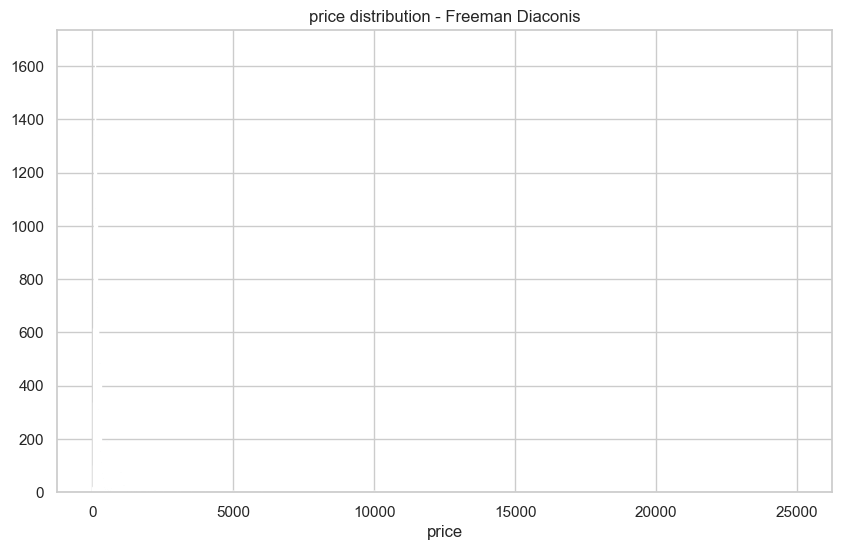

In [177]:
h = freeman_diaconis(all_listings.price)
plot_data = all_listings.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Yes - let's get rid of the 25000 listing and see if the histogram starts to make more sense

In [178]:
trimmed_listings = all_listings[all_listings.price < 1500]

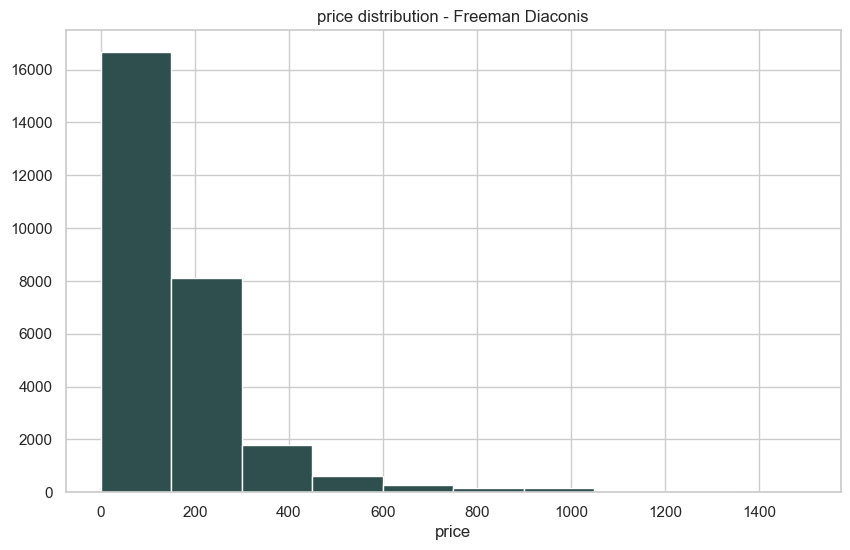

In [179]:
plot_data = trimmed_listings.price

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, color="darkslategray")
axes.set_title(variable_name + " distribution")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Removing listings below 1500 reveals a distribution with a very strong skew to the right. The distribution appears to be almost exponential which would not make much sense given our domain knowledge. Let's use Freeman Diaconis bins and limit the listings from 0-500

Freeman Diaconis:  7


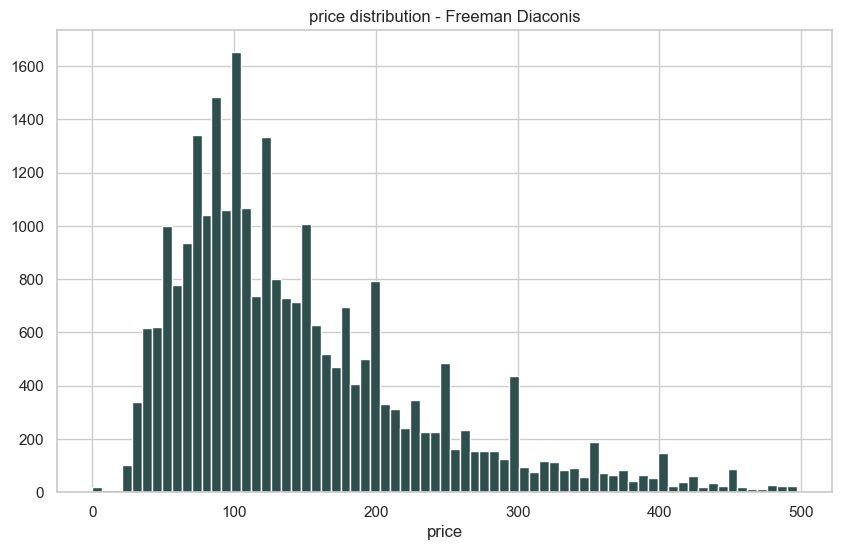

In [180]:
listings_below_500 = all_listings[all_listings.price < 500]

h = freeman_diaconis(listings_below_500.price)
plot_data = listings_below_500.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Looking at the above distribution, we see a that there is a strong skew to the right even when we remove all listings over 500 per night. This can be interpreted as the majority of AirBnBs having a nightly price that is between 85 and 200 per night but then increasingly expensive houses becomes less and less popular. 

Moving on to the single variable analysis of `neighborhoods`...

# Pairwise EDA - Target Variable: Rating <a id="pairwise_eda_rating"></a>

In [294]:
describe_by_category(latest_listings, "review_scores_rating", "neighbourhood_cleansed", transpose=True)

neighbourhood_cleansed  Brightwood Park, Crestwood, Petworth  \
count                                             416.000000   
mean                                                4.641611   
std                                                 0.674931   
min                                                 0.000000   
25%                                                 4.620000   
50%                                                 4.830000   
75%                                                 4.970000   
max                                                 5.000000   

neighbourhood_cleansed  Brookland, Brentwood, Langdon  \
count                                      130.000000   
mean                                         4.815154   
std                                          0.268103   
min                                          3.000000   
25%                                          4.750000   
50%                                          4.890000   
75%                     

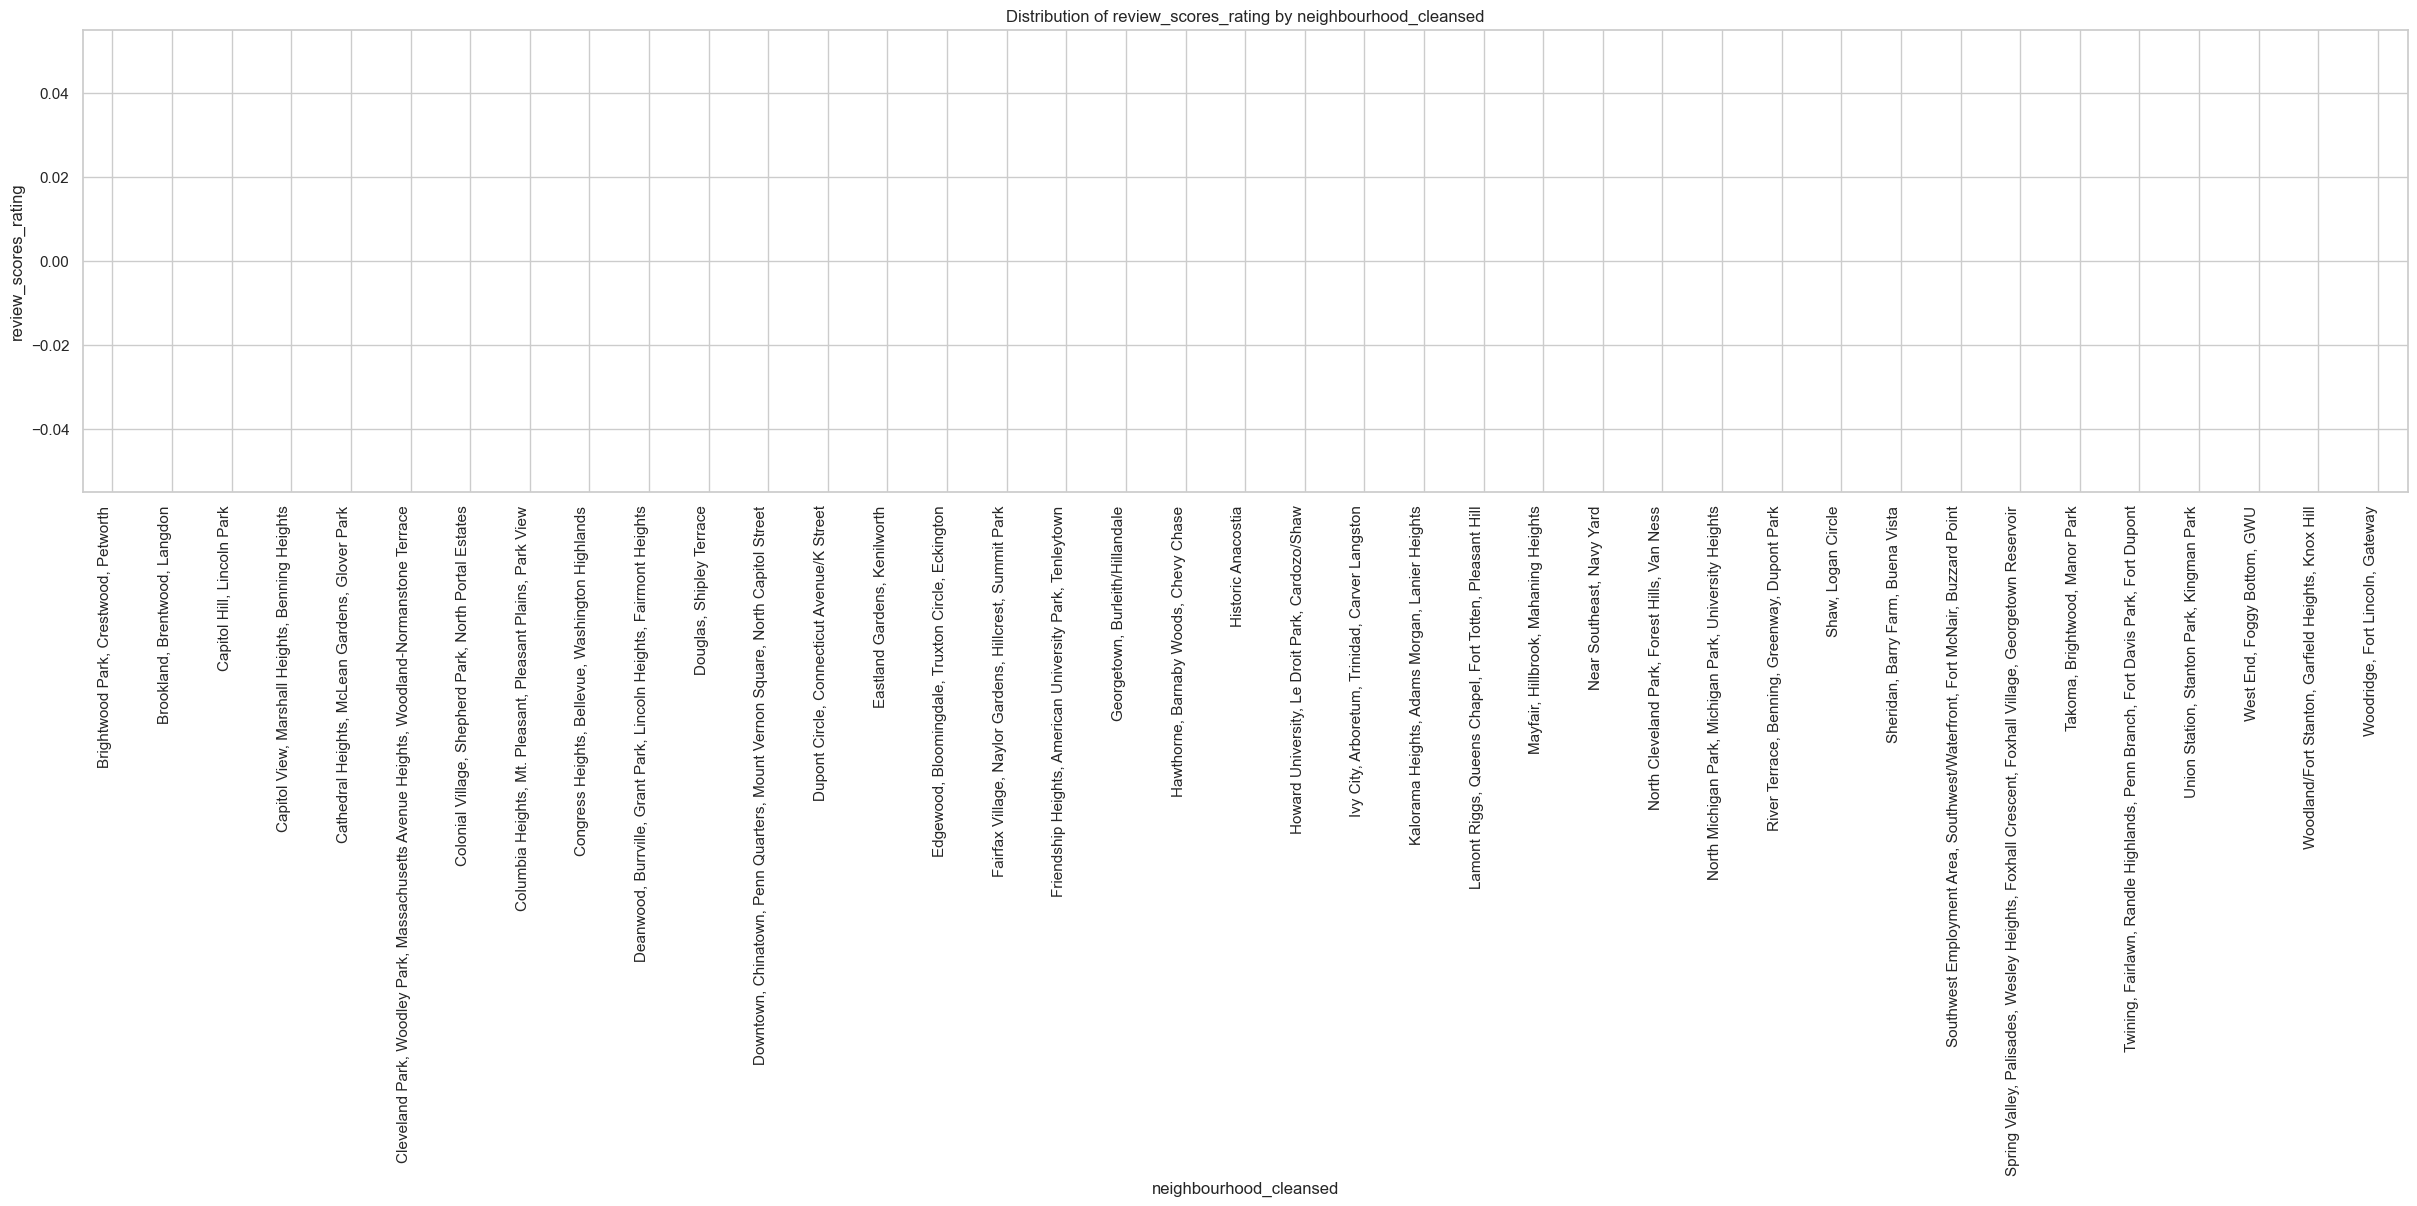

In [384]:
multiboxplot(latest_listings, "review_scores_rating", "neighbourhood_cleansed") # TODO data not showing up

TODO: Discuss

### 'neighborhood' vs 'rating' <a id="neighborhood_vs_rating"></a>

In [317]:
grouped = latest_listings.groupby("neighbourhood_cleansed")
labels = pd.unique(latest_listings_below_500["neighbourhood_cleansed"].values)
labels.sort()
grouped_data = [grouped["review_scores_rating"].get_group( k) for k in labels]
grouped_y = grouped['review_scores_rating'].describe()
avg_review_per_neighborhood = list(grouped_y.iloc[:, 1])
neighborhoods_gpd['avg_rating'] = avg_review_per_neighborhood

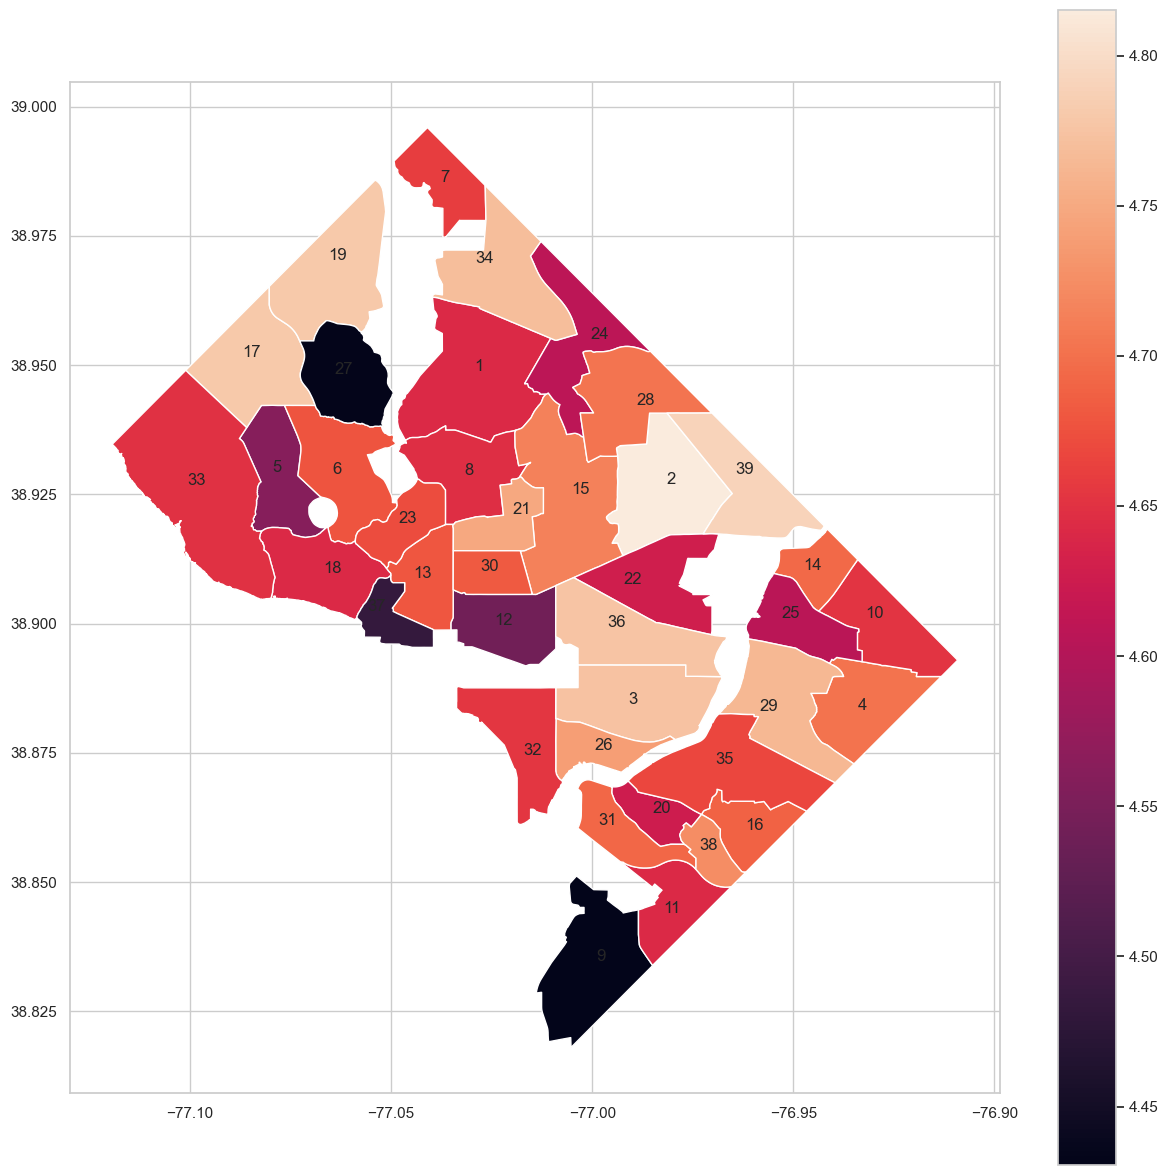

In [318]:
fig,ax = plt.subplots(figsize = (15,15))
base = neighborhoods_gpd.plot(ax=ax, column="avg_rating",legend=True)
for idx, row in neighborhoods_gpd.iterrows():
    plt.annotate(row['alpha_index'], xy=row['rep_point'],
                 horizontalalignment='center')

TODO: Discuss

In [319]:
latest_listings["years_host"] = (res - latest_listings.host_since) / np.timedelta64(1,'Y')

In [323]:
latest_listings['review_scores_rating'].isnull().values.any()

True

## `host_since` vs `review_scores_rating` <a id="host_since_vs_rating"></a>

In [329]:
latest_listings_non_null_host_since = latest_listings[(latest_listings["years_host"].notnull()) & (latest_listings["review_scores_rating"].notnull())]

In [330]:
correlation(latest_listings_non_null_host_since, "review_scores_rating", "years_host")

Correlation coefficients:
r   = 0.07123508406852085 (very weak)
rho = 0.0920592965742376 (very weak)


As I expected, the correlation is strong and negative.

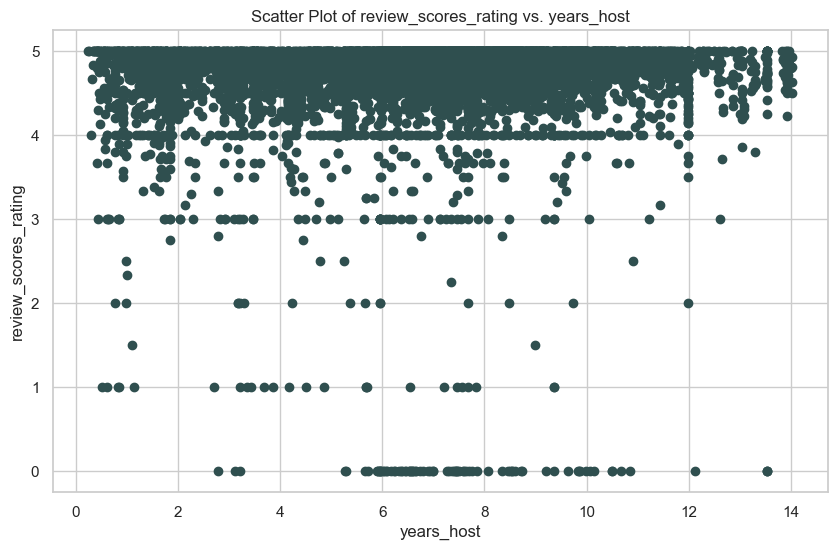

In [331]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_since.years_host, latest_listings_non_null_host_since.review_scores_rating, marker="o", color="darkslategray")

axes.set_ylabel("review_scores_rating")
axes.set_xlabel("years_host")
axes.set_title("Scatter Plot of review_scores_rating vs. years_host")

plt.show()
plt.close()

TODO: Discuss

## `host_location` vs `review_scores_rating` <a id="host_location_vs_rating"></a>
 
This one won't work because the data is ambiguous in category. There are several categories meaning the same thing like "DC" and "Washington DC" or "United States" and "US" all being separate categories.

## `host_response_time` vs `review_scores_rating` <a id="host_response_time_vs_rating"></a>

In [332]:
describe_by_category(latest_listings, "review_scores_rating", "host_response_time", transpose=True)

host_response_time          N/A  a few days or more  within a day  \
count               2010.000000          136.000000    477.000000   
mean                   4.604517            4.467941      4.665723   
std                    0.936675            1.035860      0.621095   
min                    0.000000            0.000000      0.000000   
25%                    4.672500            4.527500      4.630000   
50%                    4.880000            4.800000      4.840000   
75%                    5.000000            4.977500      5.000000   
max                    5.000000            5.000000      5.000000   

host_response_time  within a few hours  within an hour  
count                       830.000000     4156.000000  
mean                          4.691614        4.725416  
std                           0.534205        0.420487  
min                           0.000000        0.000000  
25%                           4.610000        4.670000  
50%                           4.8400

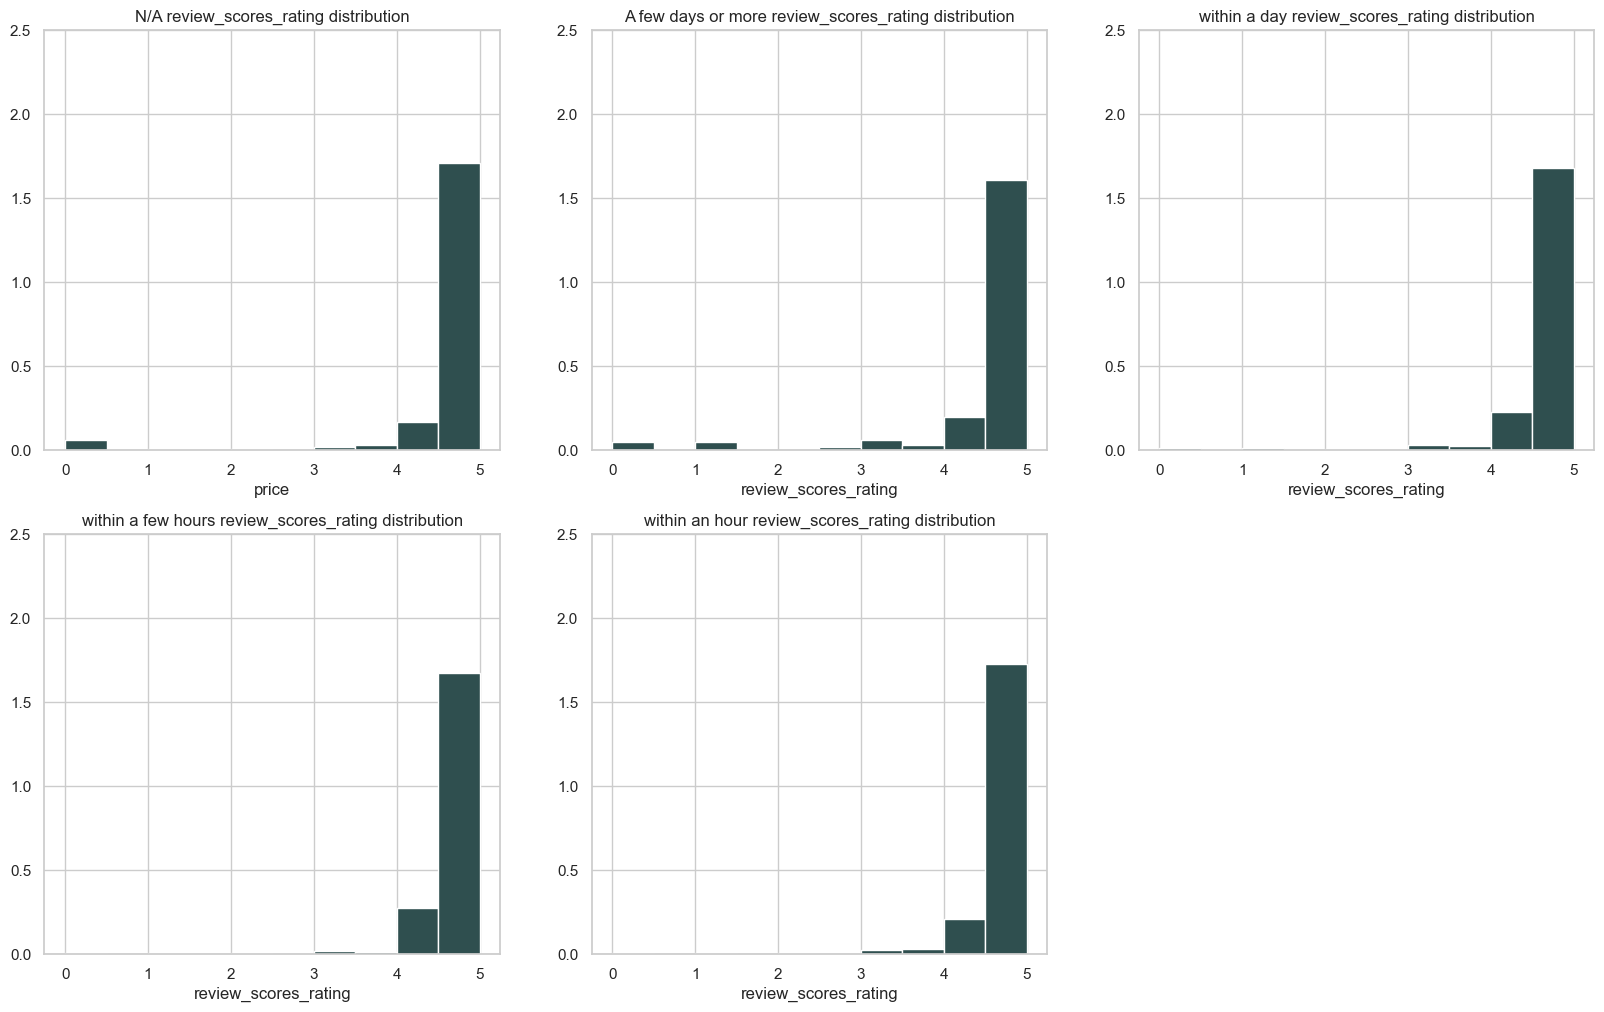

In [337]:
grouped = latest_listings_below_500.groupby("host_response_time")

figure = plt.figure(figsize=(20, 12))

axes = figure.add_subplot(2, 3, 1)
axes.hist(grouped["review_scores_rating"].get_group("N/A"),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2.5))
axes.set_title("N/A review_scores_rating distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(2, 3, 2)
axes.hist(grouped["review_scores_rating"].get_group("a few days or more"),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2.5))
axes.set_title("A few days or more review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

axes = figure.add_subplot(2, 3, 3)
axes.hist(grouped["review_scores_rating"].get_group("within a day"),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2.5))
axes.set_title("within a day review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

axes = figure.add_subplot(2, 3, 4)
axes.hist(grouped["review_scores_rating"].get_group("within a few hours"),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2.5))
axes.set_title("within a few hours review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

axes = figure.add_subplot(2, 3, 5)
axes.hist(grouped["review_scores_rating"].get_group("within an hour"),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2.5))
axes.set_title("within an hour review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

plt.show()
plt.close()

TODO: Discuss

## `host_response_rate` vs `review_scores_rating` <a id="host_response_rate_vs_rating"></a>

In [339]:
latest_listings['host_response_rate'] = latest_listings['host_response_rate'].replace('N/A',np.NaN)
latest_listings['host_response_rate'] = latest_listings['host_response_rate'].replace('%', '', regex=True).astype(float)

In [340]:
latest_listings['host_response_rate'].isnull().values.any()

True

In [342]:
latest_listings_non_null_host_response_rate = latest_listings[latest_listings["host_response_rate"].notnull() & (latest_listings["review_scores_rating"].notnull())]

In [343]:
correlation(latest_listings_non_null_host_response_rate, "review_scores_rating", "host_response_rate")

Correlation coefficients:
r   = 0.12900964402565684 (very weak)
rho = 0.17953795586786078 (weak)


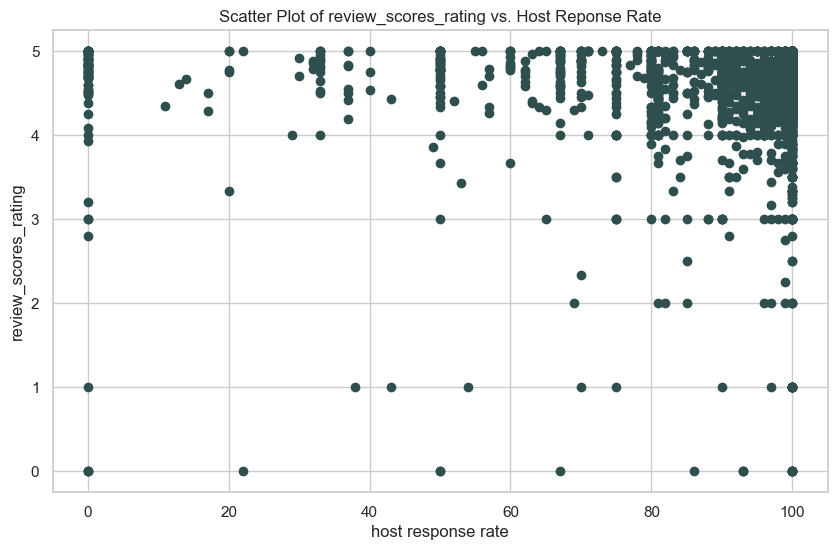

In [344]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_response_rate.host_response_rate, latest_listings_non_null_host_response_rate.review_scores_rating, marker="o", color="darkslategray")

axes.set_ylabel("review_scores_rating")
axes.set_xlabel("host response rate")
axes.set_title("Scatter Plot of review_scores_rating vs. Host Reponse Rate")

plt.show()
plt.close()

TODO: Discuss

## `host_acceptance_rate` vs `review_scores_rating` <a id="host_acceptance_rate_vs_rating"></a>

In [345]:
latest_listings['host_acceptance_rate'] = latest_listings['host_acceptance_rate'].replace('N/A',np.NaN)
latest_listings['host_acceptance_rate'] = latest_listings['host_acceptance_rate'].replace('%', '', regex=True).astype(float)

In [346]:
latest_listings['host_response_rate'].isnull().values.any()

True

In [347]:
latest_listings_non_null_host_acceptance_rate = latest_listings[latest_listings["host_acceptance_rate"].notnull() & (latest_listings["review_scores_rating"].notnull())]

In [348]:
correlation(latest_listings_non_null_host_acceptance_rate, "review_scores_rating", "host_acceptance_rate")

Correlation coefficients:
r   = 0.08305911272581257 (very weak)
rho = 0.02339755258475468 (very weak)


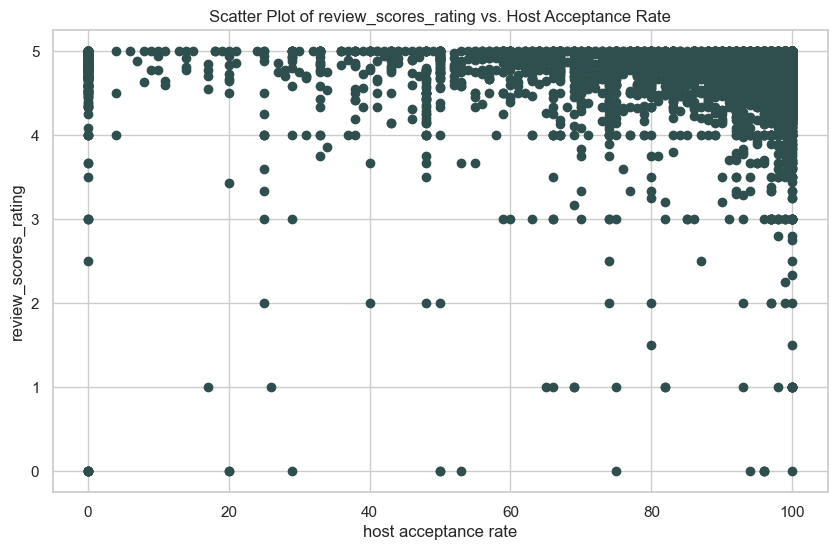

In [349]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_acceptance_rate.host_acceptance_rate, latest_listings_non_null_host_acceptance_rate.review_scores_rating, marker="o", color="darkslategray")

axes.set_ylabel("review_scores_rating")
axes.set_xlabel("host acceptance rate")
axes.set_title("Scatter Plot of review_scores_rating vs. Host Acceptance Rate")

plt.show()
plt.close()

TODO: Discuss

## `host_is_superhost` vs `review_scores_rating` <a id="host_is_superhost_vs_rating"></a>

In [350]:
latest_listings['host_is_superhost'].isnull().values.any()

True

In [351]:
latest_listings_non_null_host_is_superhost = latest_listings[latest_listings["host_is_superhost"].notnull()]

In [352]:
describe_by_category(latest_listings, "review_scores_rating", "host_is_superhost", transpose=True)

host_is_superhost        False         True
count              5228.000000  2509.000000
mean                  4.589294     4.871666
std                   0.750209     0.154819
min                   0.000000     2.000000
25%                   4.530000     4.830000
50%                   4.780000     4.900000
75%                   5.000000     4.960000
max                   5.000000     5.000000


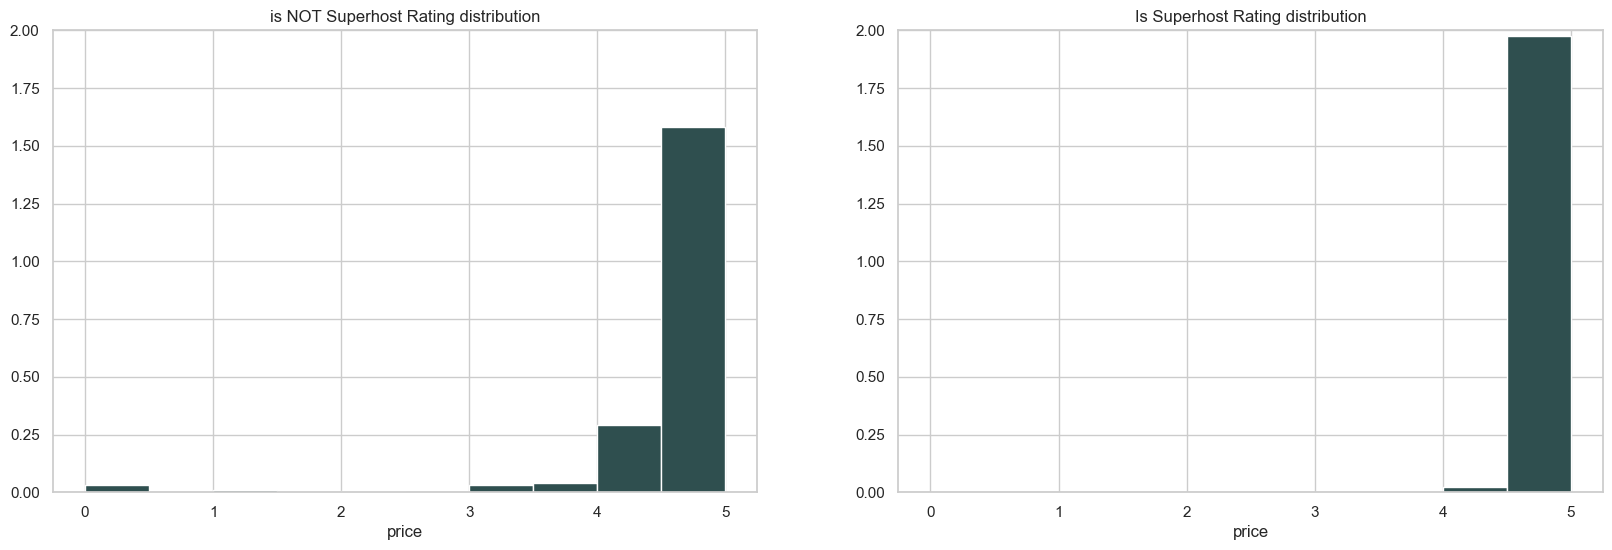

In [356]:
grouped = latest_listings.groupby("host_is_superhost")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["review_scores_rating"].get_group(False),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("is NOT Superhost Rating distribution")
axes.set_xlabel("price")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["review_scores_rating"].get_group(True),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("Is Superhost Rating distribution")
axes.set_xlabel("price")

plt.show()
plt.close()

TODO: Discuss

## `host_listings_count` vs `review_scores_rating` <a id="host_listings_count_vs_rating"></a>

In [357]:
latest_listings['host_listings_count'].isnull().values.any()

True

In [360]:
latest_listings_non_null_host_listings_count = latest_listings[latest_listings["host_listings_count"].notnull() & (latest_listings["review_scores_rating"].notnull())]

In [361]:
correlation(latest_listings_non_null_host_listings_count , "review_scores_rating", "host_listings_count")

Correlation coefficients:
r   = -0.04056181809422287 (very weak)
rho = -0.21680666425614878 (weak)


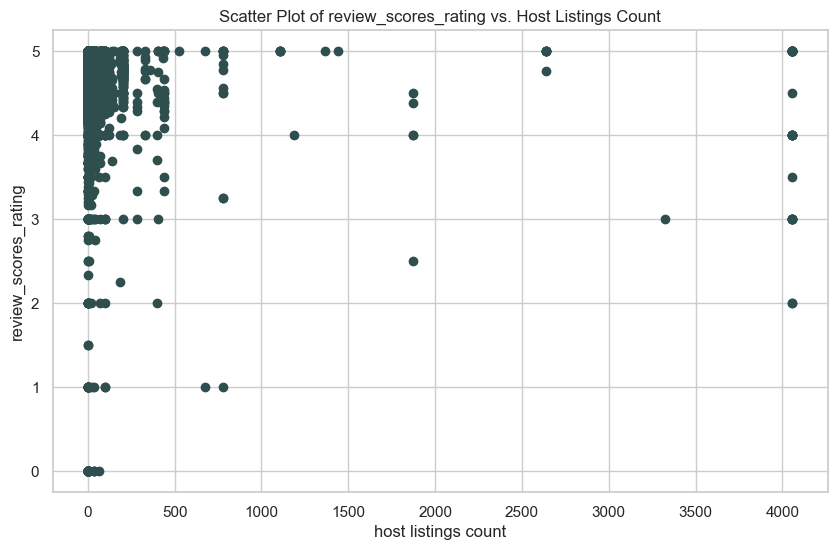

In [362]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_listings_count.host_listings_count, latest_listings_non_null_host_listings_count.review_scores_rating, marker="o", color="darkslategray")

axes.set_ylabel("review_scores_rating")
axes.set_xlabel("host listings count")
axes.set_title("Scatter Plot of review_scores_rating vs. Host Listings Count")

plt.show()
plt.close()

TODO: Discuss

In [365]:
latest_listings['host_listings_count_under_20'] = latest_listings.host_listings_count[latest_listings.host_listings_count < 20]

In [366]:
latest_listings_non_null_host_listings_under_20_count = latest_listings[latest_listings["host_listings_count_under_20"].notnull() & (latest_listings["review_scores_rating"].notnull())]

In [367]:
correlation(latest_listings_non_null_host_listings_under_20_count , "review_scores_rating", "host_listings_count_under_20")

Correlation coefficients:
r   = -0.019969452346313973 (very weak)
rho = -0.1829743493894682 (weak)


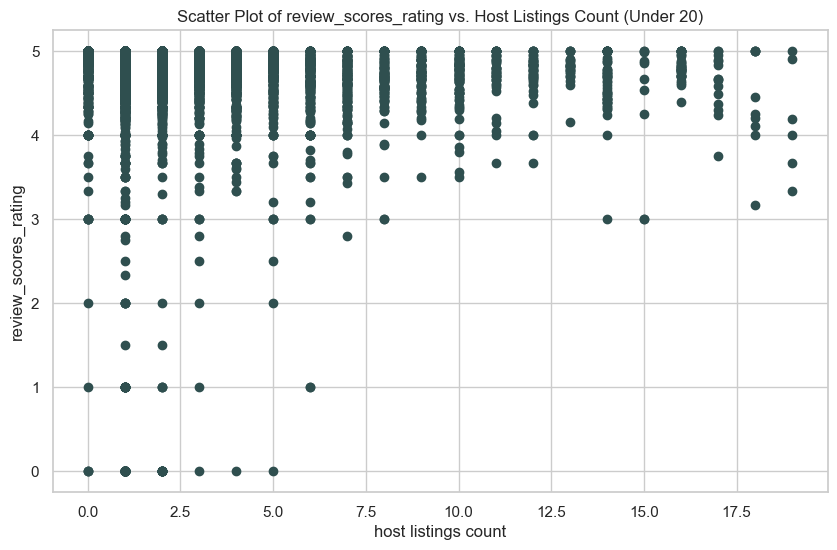

In [369]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( latest_listings_non_null_host_listings_under_20_count.host_listings_count_under_20, latest_listings_non_null_host_listings_under_20_count.review_scores_rating, marker="o", color="darkslategray")

axes.set_ylabel("review_scores_rating")
axes.set_xlabel("host listings count")
axes.set_title("Scatter Plot of review_scores_rating vs. Host Listings Count (Under 20)")

plt.show()
plt.close()

TODO: Discuss

## `host_total_listings_count` vs `review_scores_rating` <a id="host_total_listings_count_vs_rating"></a>
UNUSED

## `host_verifications` vs `review_scores_rating` <a id="host_verifications_vs_rating"></a>

In [145]:
latest_listings.host_verifications.value_counts(normalize=True)[:10]

['email', 'phone']                                                                                    0.550095
['email', 'phone', 'work_email']                                                                      0.136080
['phone']                                                                                             0.051705
['email', 'phone', 'reviews', 'kba']                                                                  0.024716
['email', 'phone', 'reviews', 'jumio', 'government_id']                                               0.016004
None                                                                                                  0.015341
['email', 'phone', 'reviews']                                                                         0.014583
['email', 'phone', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']    0.010511
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']                      0.010133
[

## `host_has_profile_pic` vs `review_scores_rating` <a id="host_has_profile_pic_vs_rating"></a>

In [371]:
describe_by_category(latest_listings, "review_scores_rating", "host_has_profile_pic", transpose=True)

host_has_profile_pic      False         True
count                 43.000000  7566.000000
mean                   4.542093     4.682240
std                    0.652696     0.637028
min                    2.000000     0.000000
25%                    4.250000     4.662500
50%                    4.800000     4.850000
75%                    5.000000     4.970000
max                    5.000000     5.000000


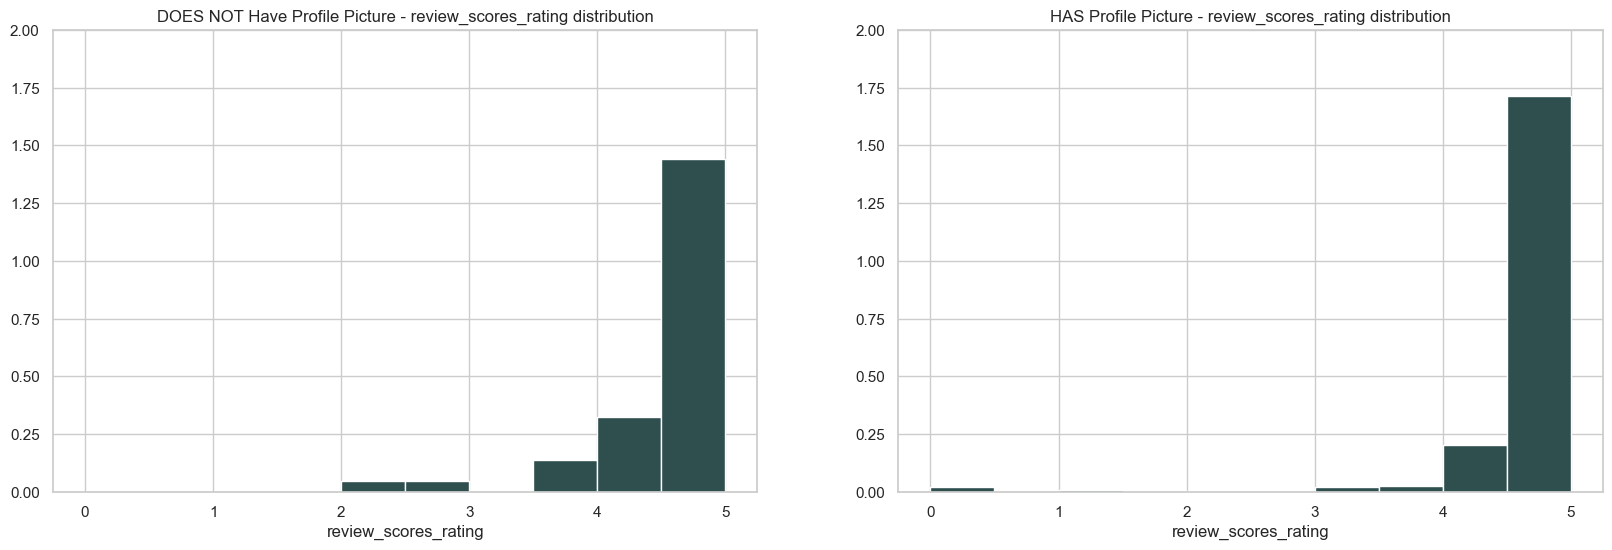

In [373]:
grouped = latest_listings.groupby("host_has_profile_pic")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["review_scores_rating"].get_group(False),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("DOES NOT Have Profile Picture - review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["review_scores_rating"].get_group(True),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("HAS Profile Picture - review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

plt.show()
plt.close()

TODO: Discuss

## `host_identity_verified` vs `host_identity_verified` <a id="host_identity_verified_vs_rating"></a>

In [374]:
describe_by_category(latest_listings, "review_scores_rating", "host_identity_verified", transpose=True)

host_identity_verified        False         True
count                   1253.000000  6356.000000
mean                       4.618204     4.693916
std                        0.783510     0.603433
min                        0.000000     0.000000
25%                        4.620000     4.670000
50%                        4.830000     4.850000
75%                        4.970000     4.970000
max                        5.000000     5.000000


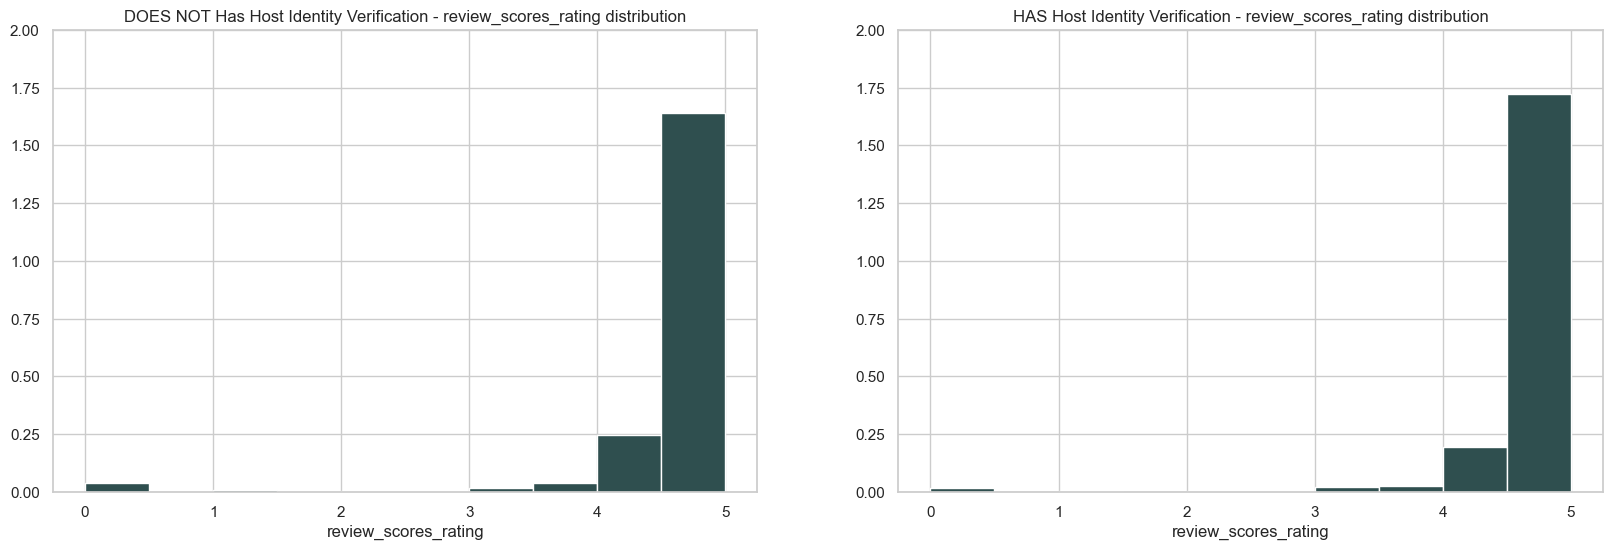

In [376]:
grouped = latest_listings.groupby("host_identity_verified")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1,2, 1)
axes.hist(grouped["review_scores_rating"].get_group(False),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("DOES NOT Has Host Identity Verification - review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

axes = figure.add_subplot(1,2, 2)
axes.hist(grouped["review_scores_rating"].get_group(True),color="darkslategray",density=True, range=(0,5))
axes.set_ylim((0,2))
axes.set_title("HAS Host Identity Verification - review_scores_rating distribution")
axes.set_xlabel("review_scores_rating")

plt.show()
plt.close()

TODO: Discuss